Alt_airports file is empty
Observation shape: (1, 11, 33)
Step 0:


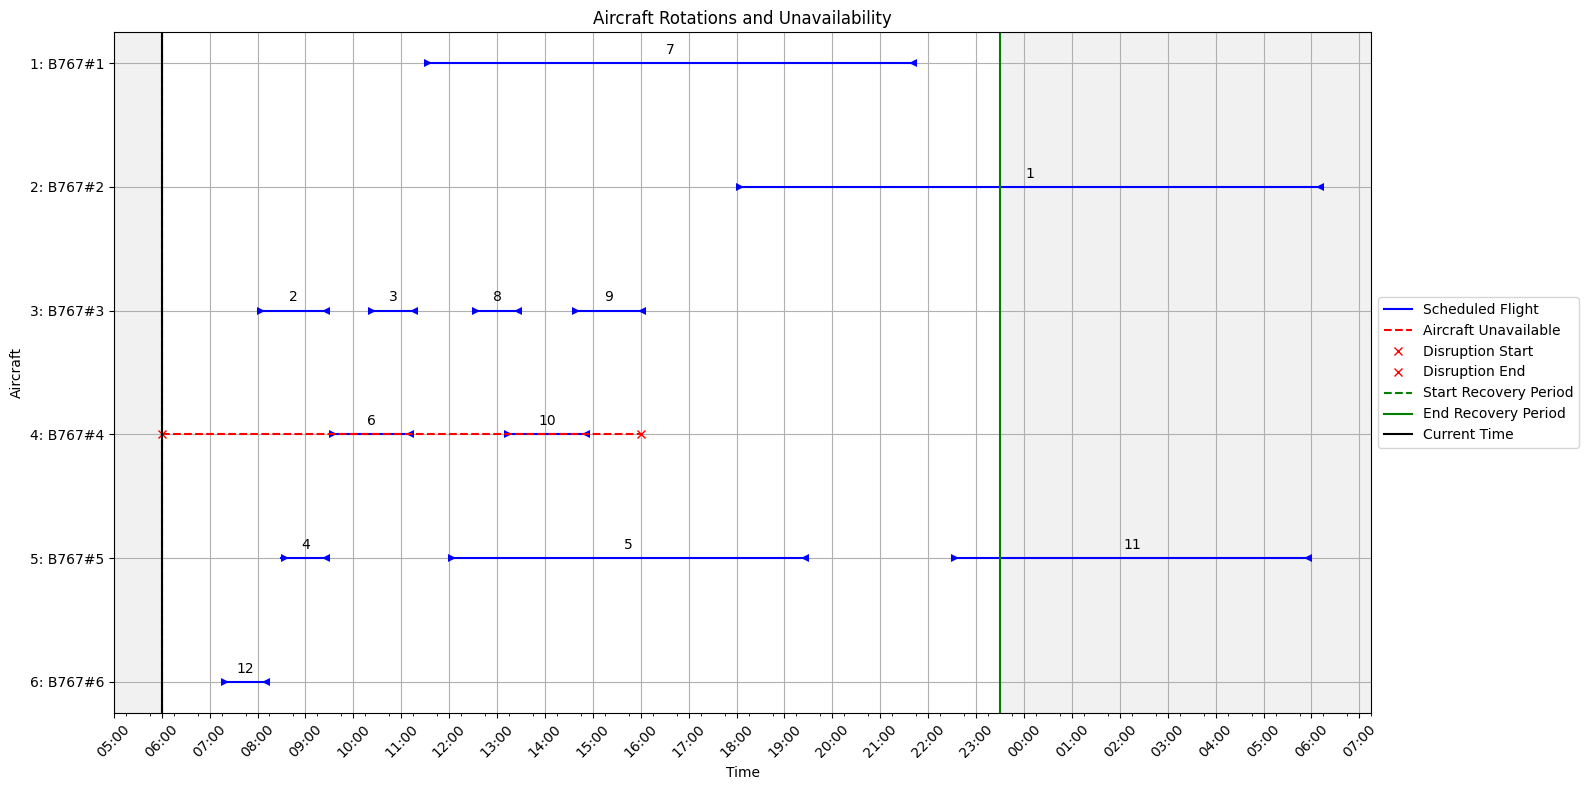

Updating flight times for flight 6.0
 - previous times: 09:30 11:15
 - new times: 09:30 11:15
Action taken: [1], Reward: 1000.0
Step 1:


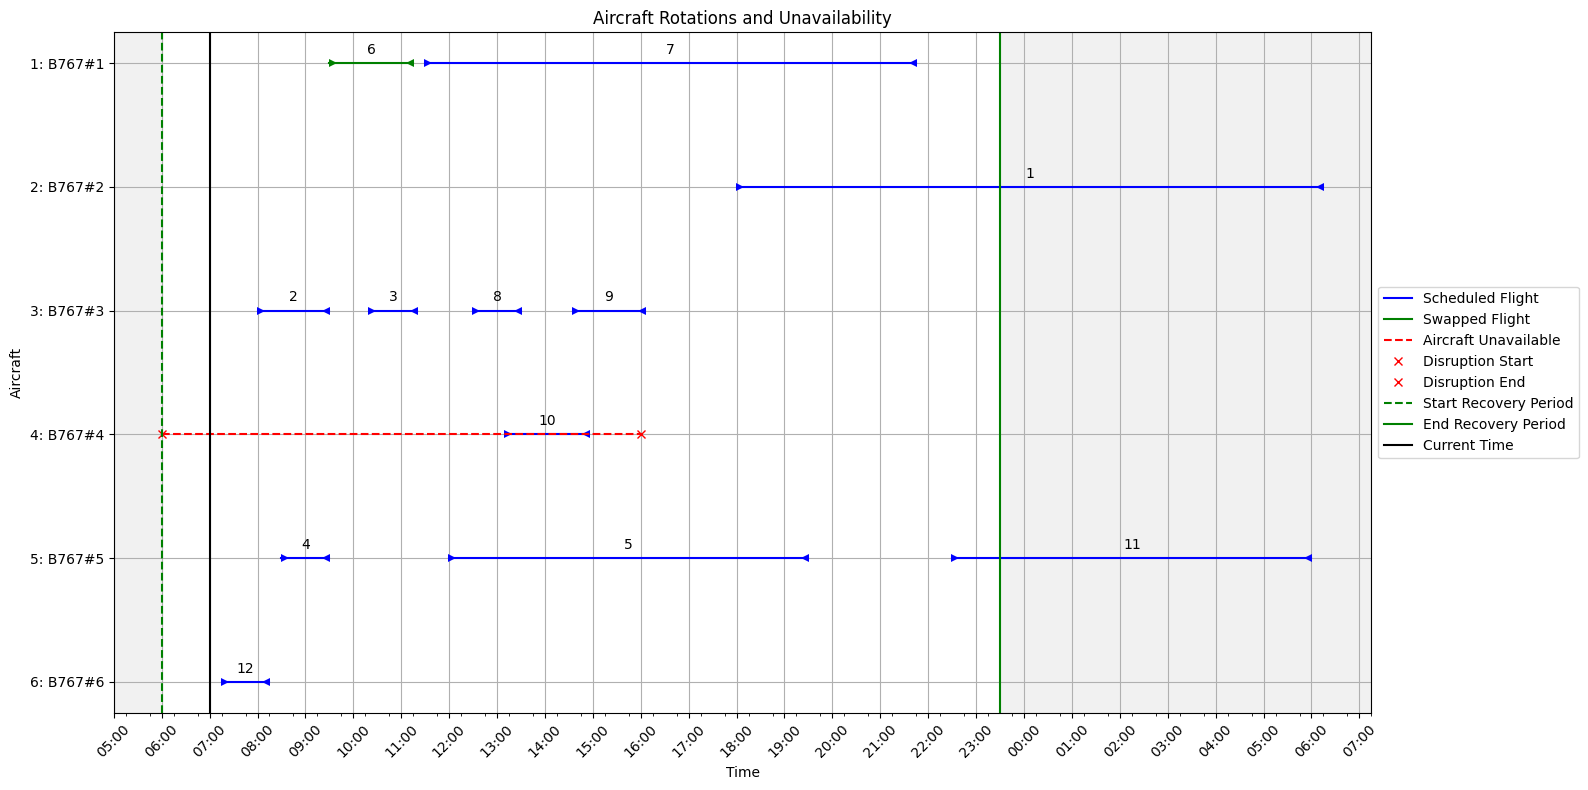

Updating flight times for flight 5.0
 - previous times: 12:00 19:30
 - new times: 14:55 22:25
Updating flight times for flight 5.0
 - previous times: 14:55 22:25
 - new times: 14:55 22:25
Updating flight times for flight 10.0
 - previous times: 13:10 14:55
 - new times: 13:10 14:55
Action taken: [5], Reward: 4125.0
Step 2:


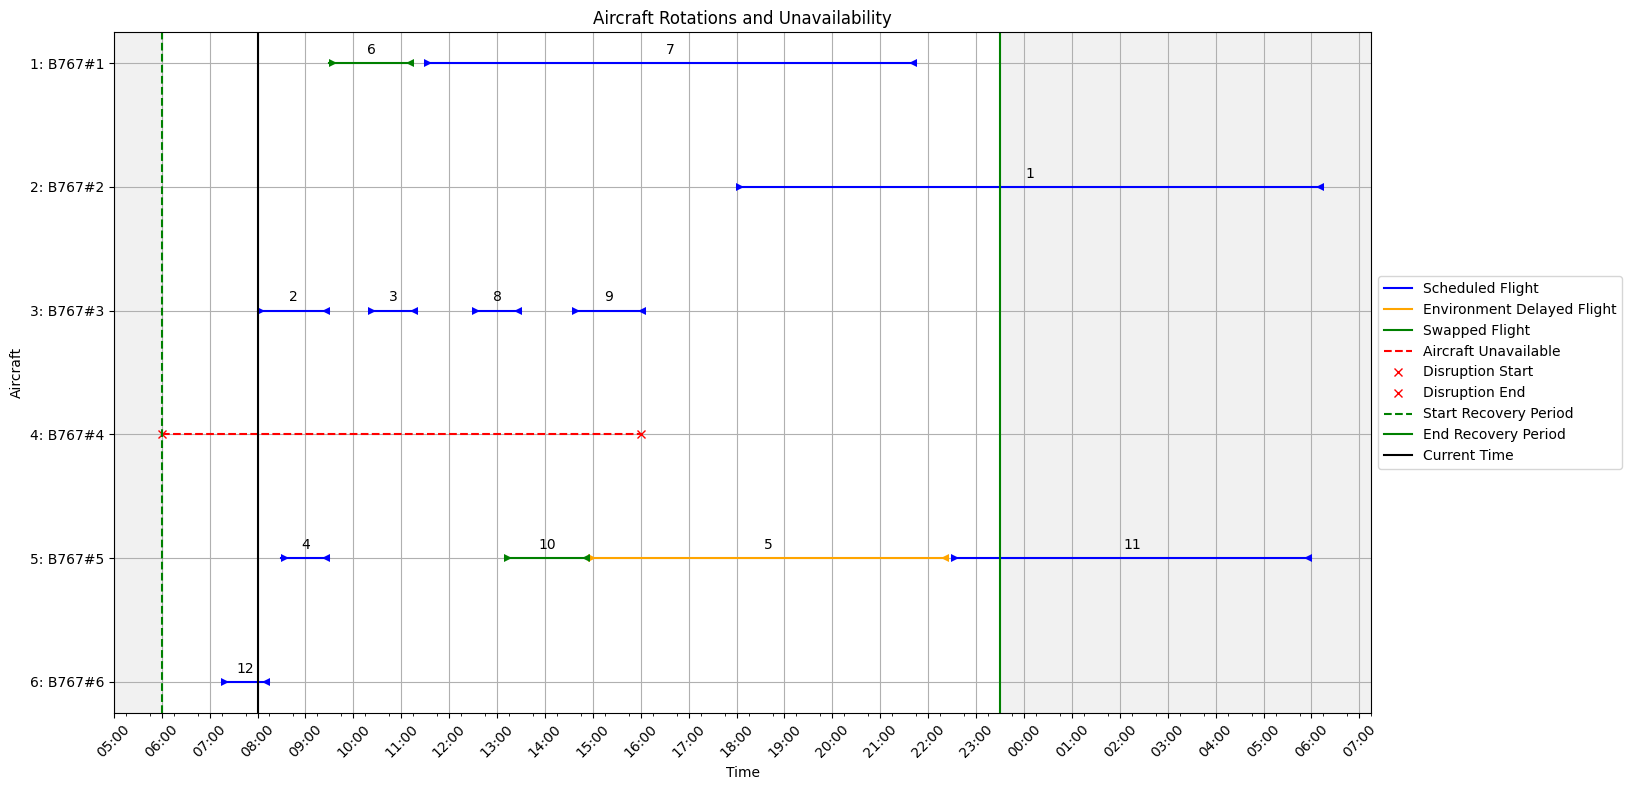

Action taken: [1], Reward: 0.0
Step 3:


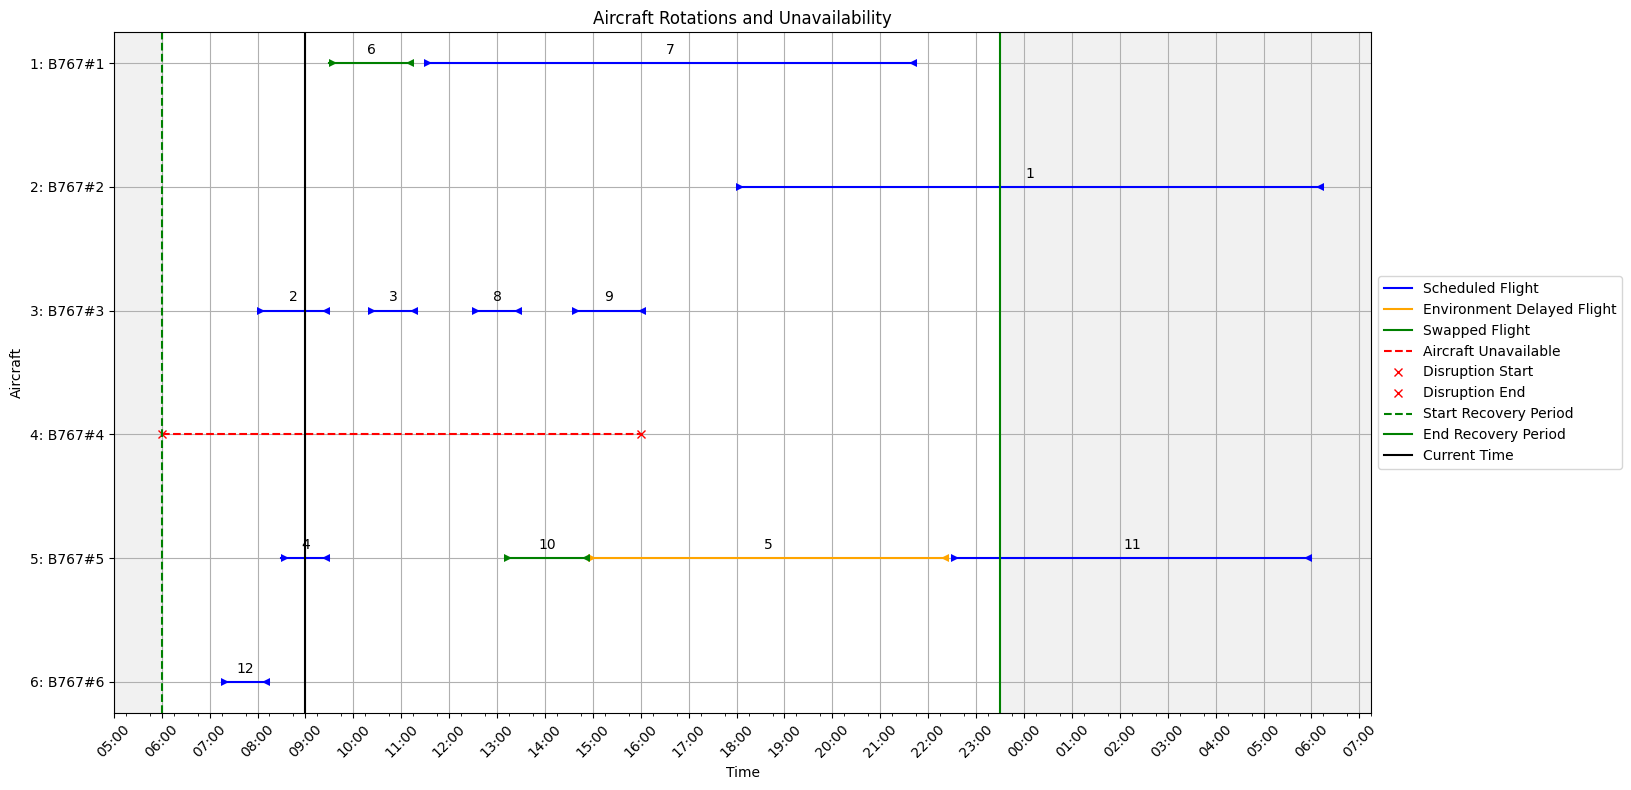

Action taken: [0], Reward: 0.0
Step 4:


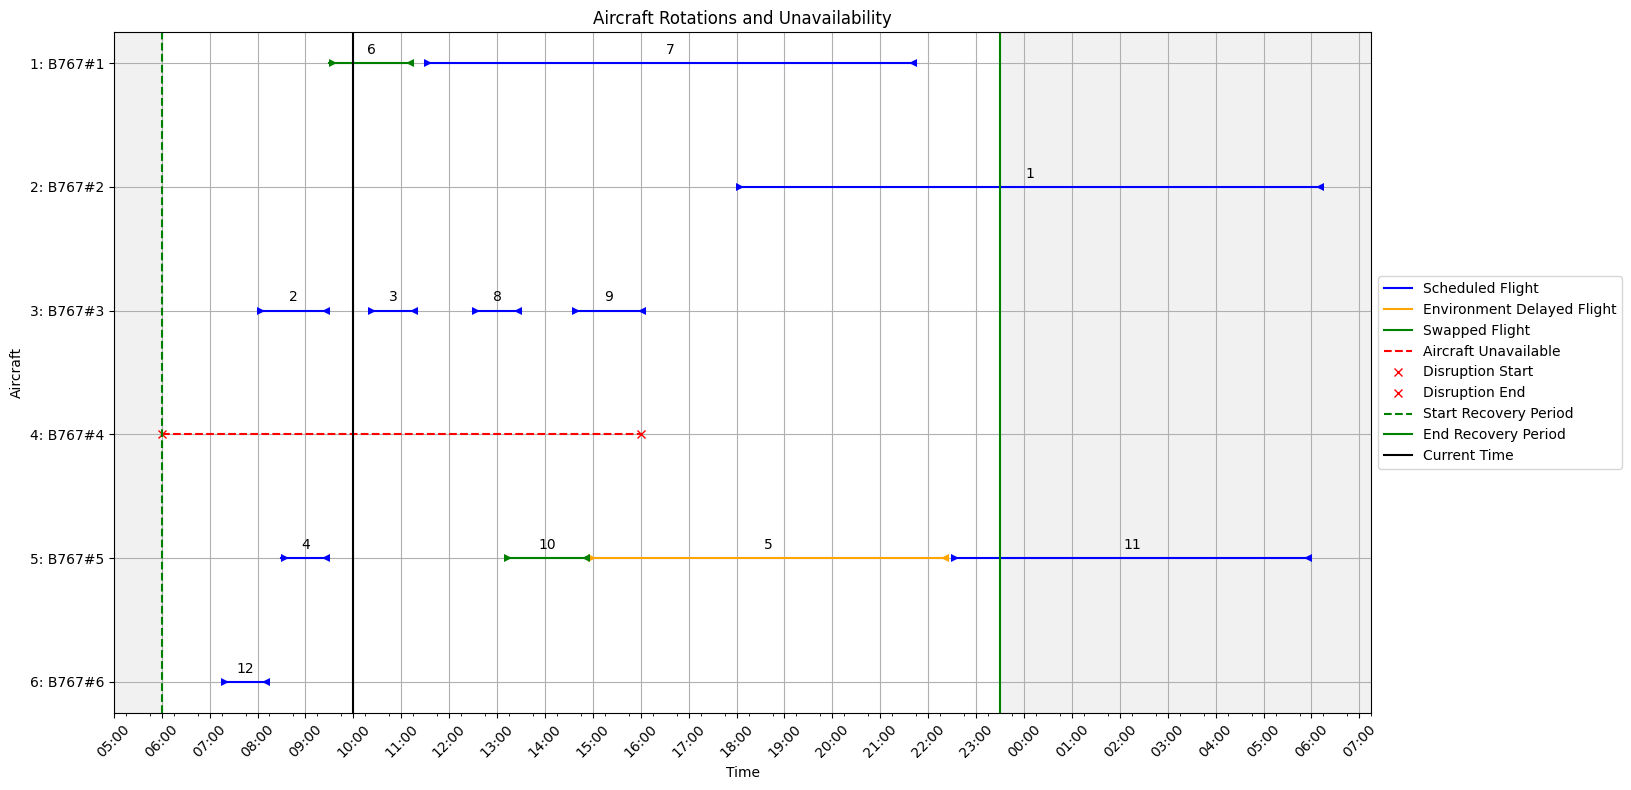

Action taken: [5], Reward: 0.0
Step 5:


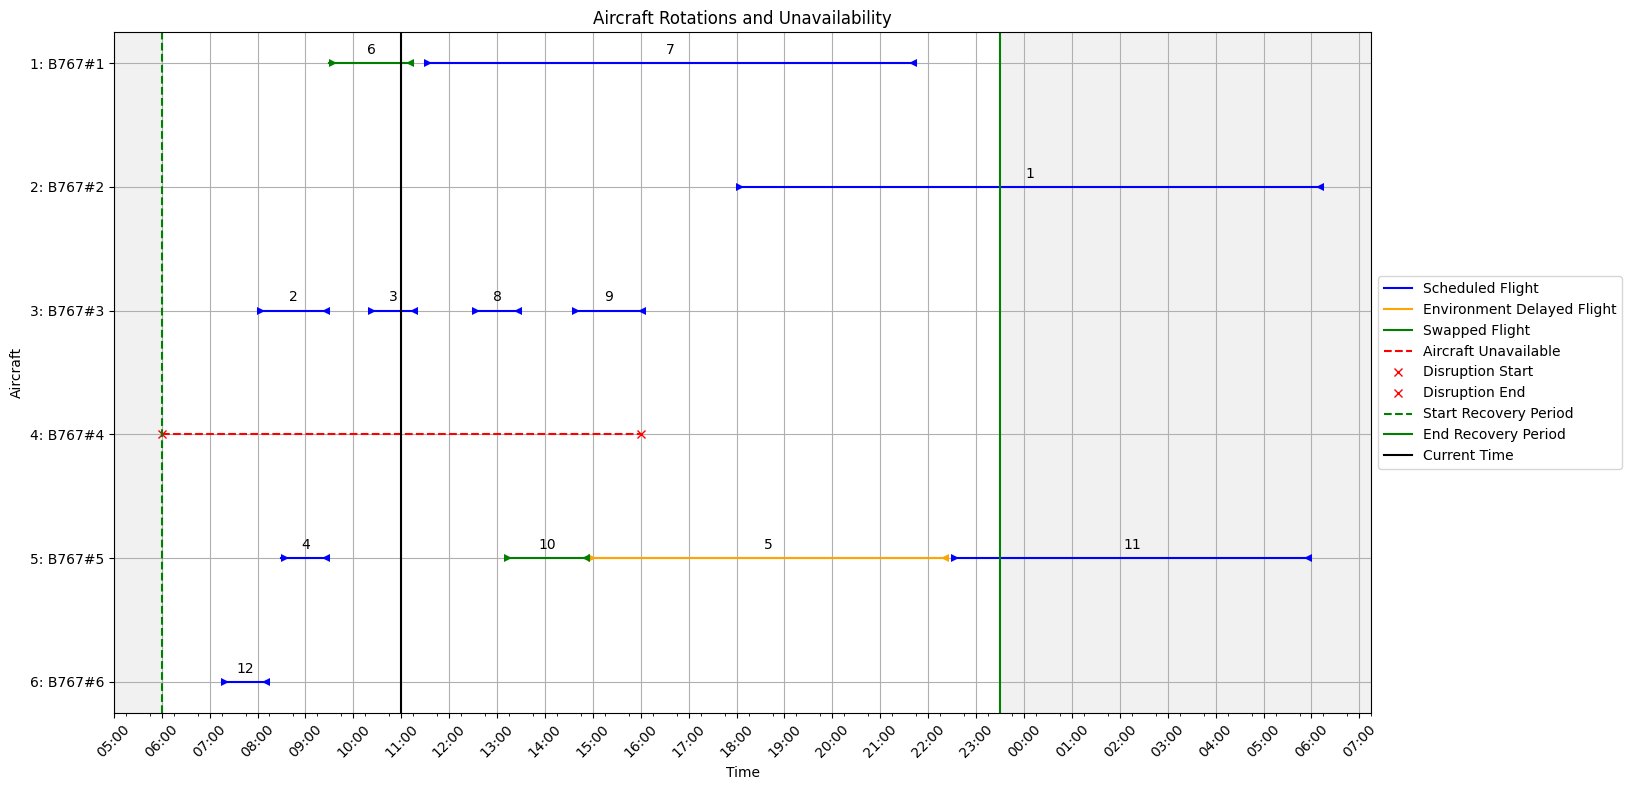

Action taken: [5], Reward: 0.0
Step 6:


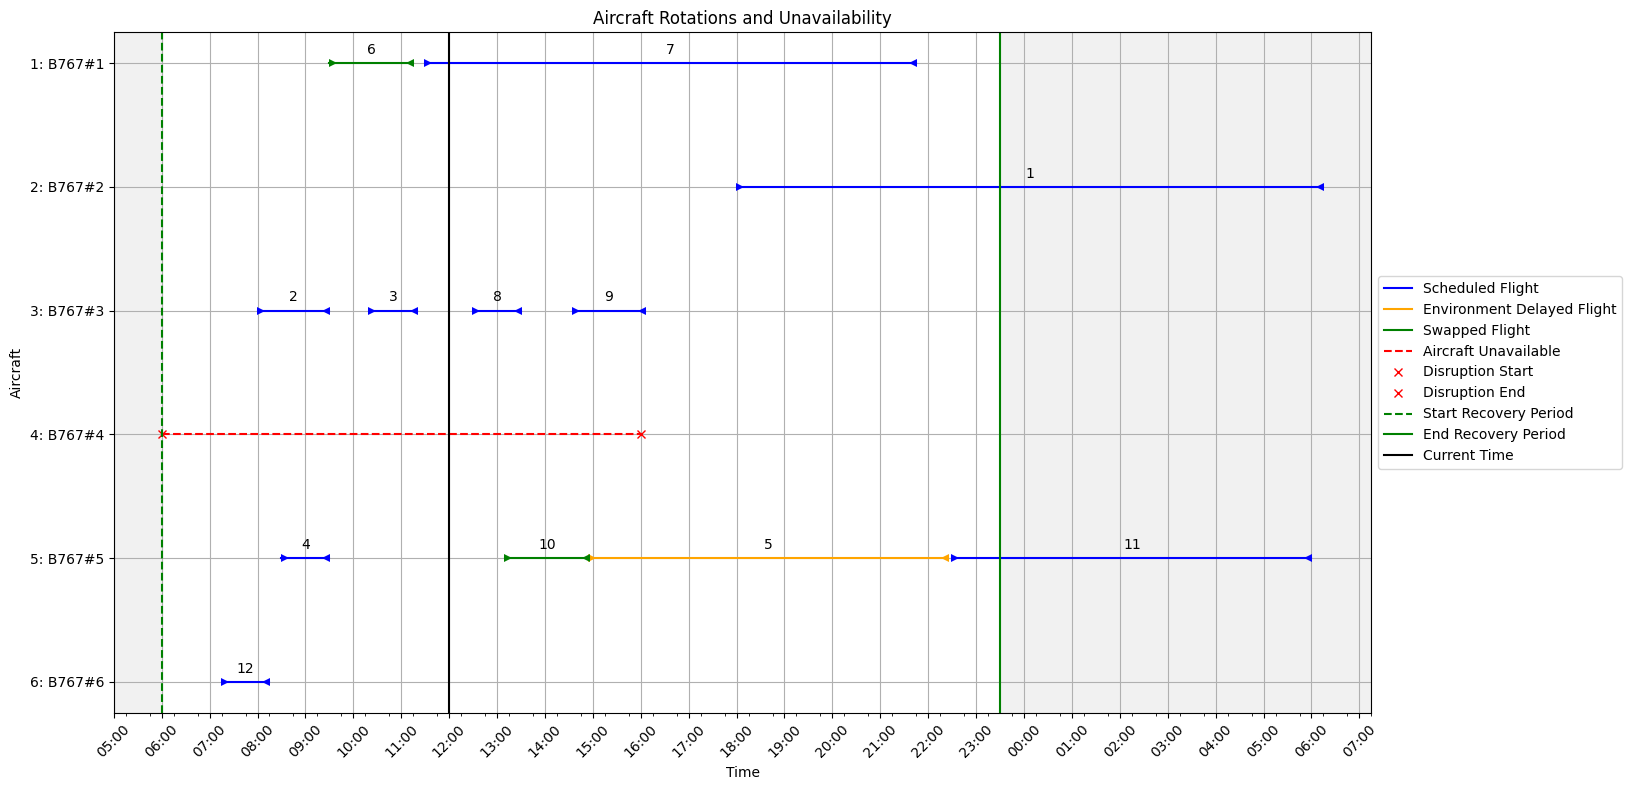

Action taken: [6], Reward: 0.0
Step 7:


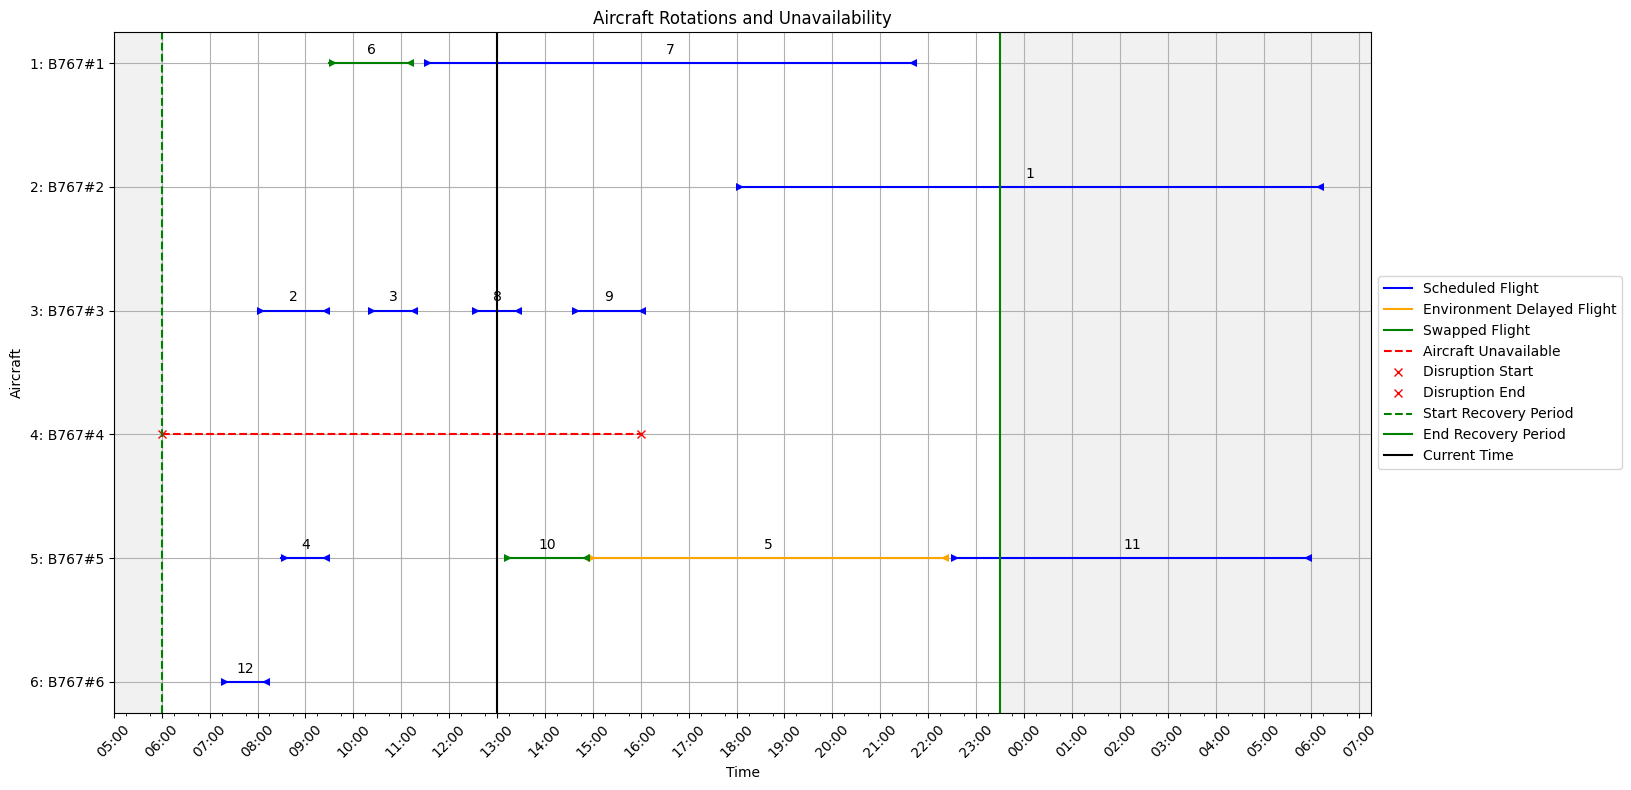

Action taken: [3], Reward: 0.0
Step 8:


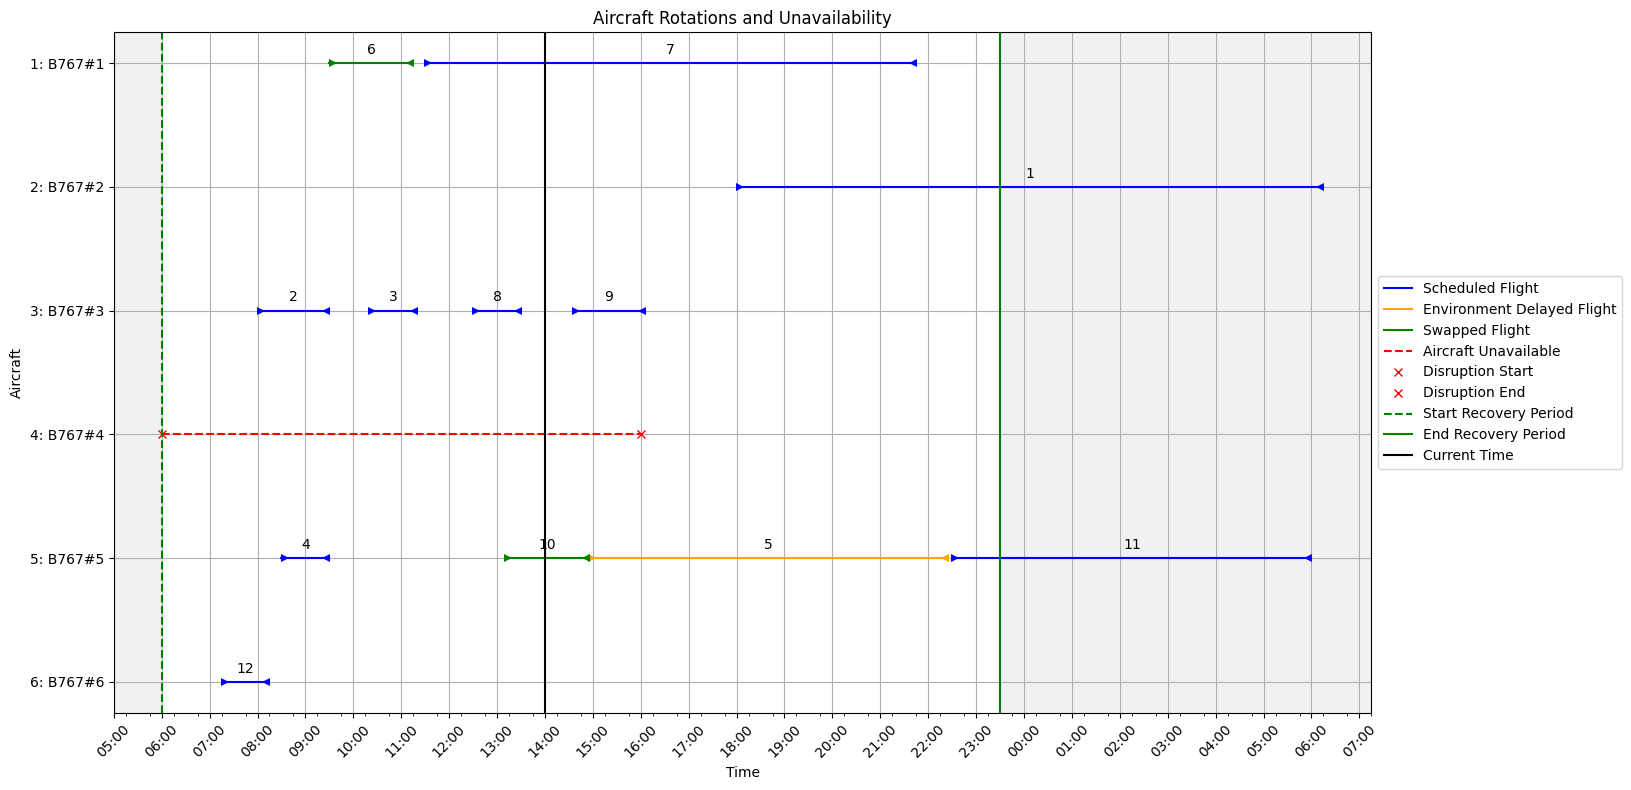

Action taken: [1], Reward: 0.0
Step 9:


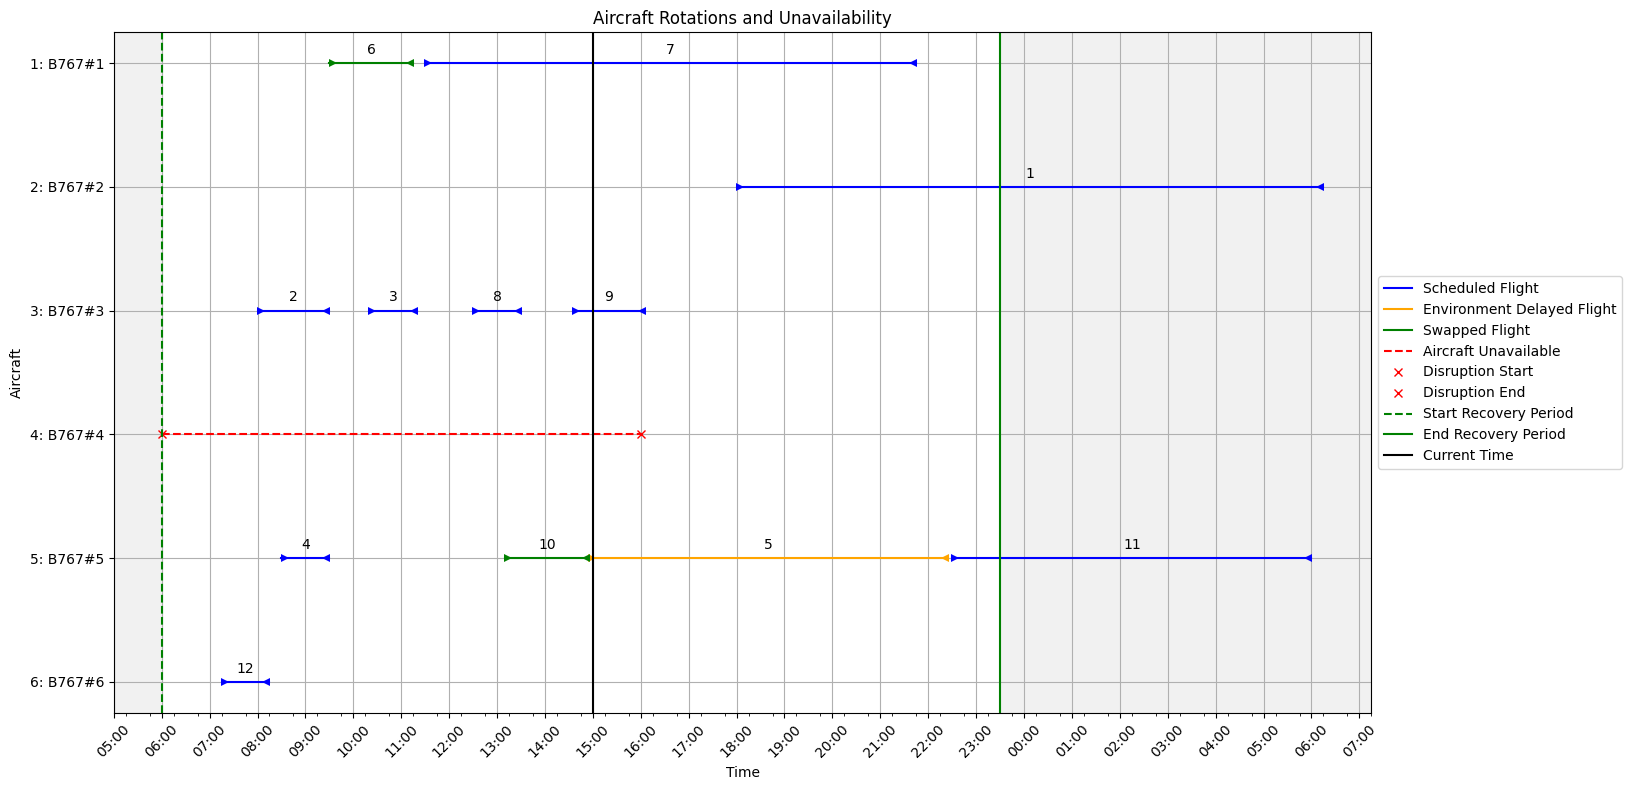

Action taken: [4], Reward: 0.0
Step 10:


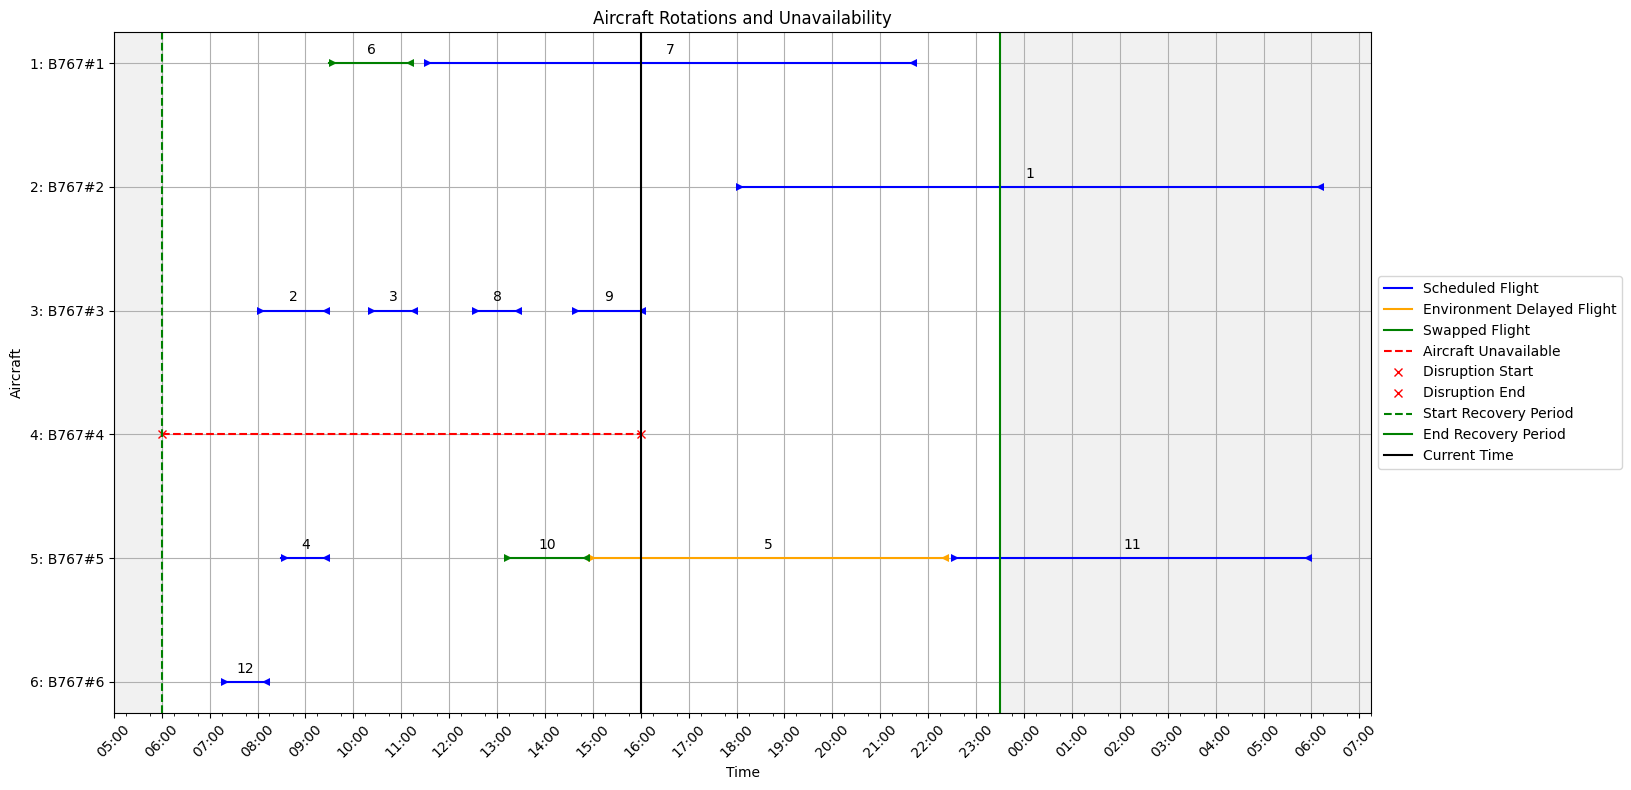

Action taken: [3], Reward: 0.0
Step 11:


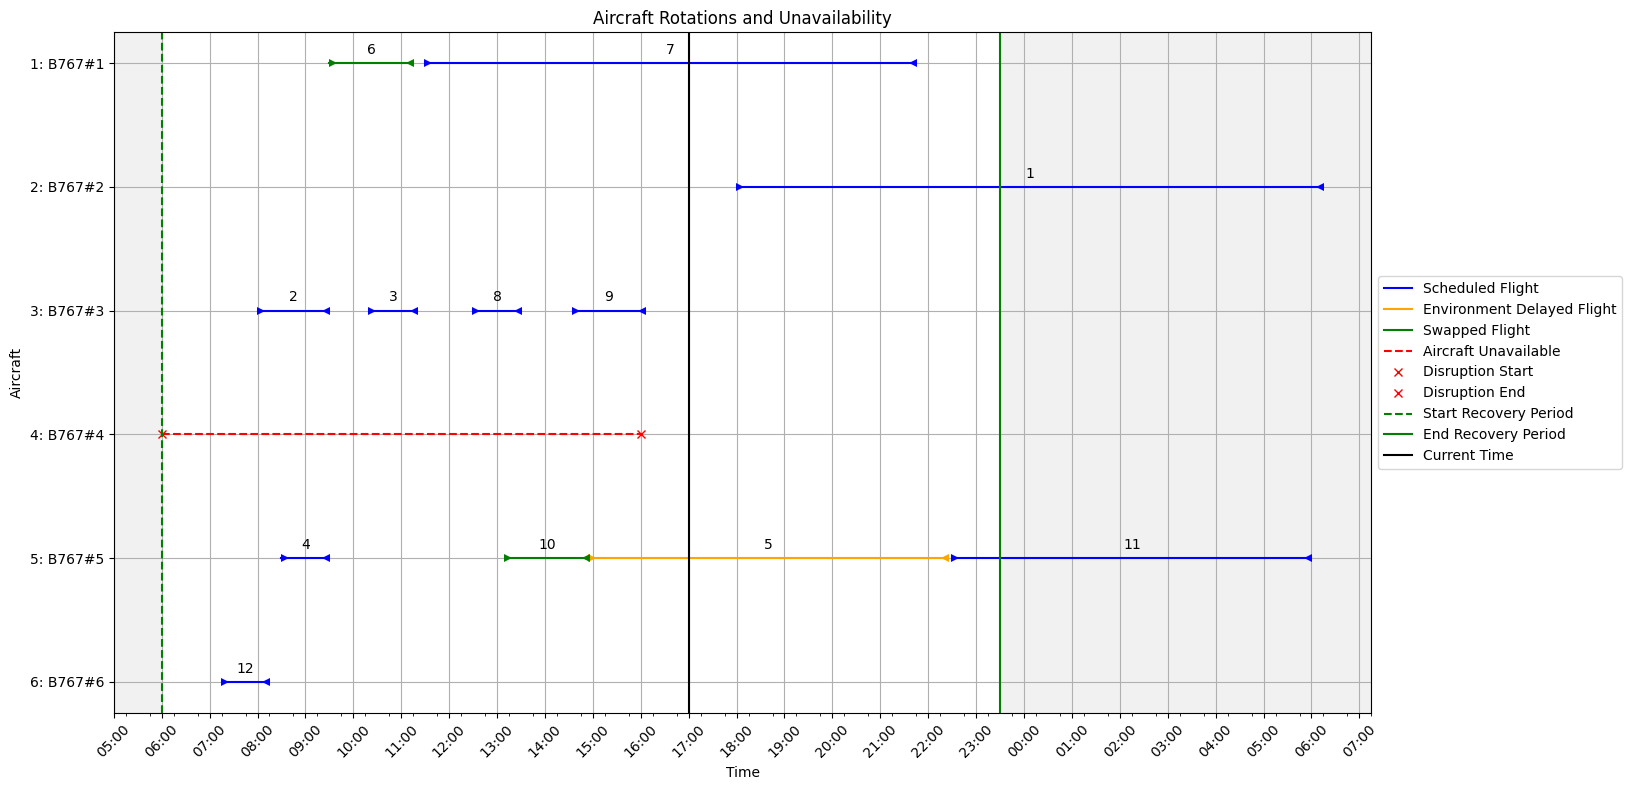

Action taken: [1], Reward: 0.0
Step 12:


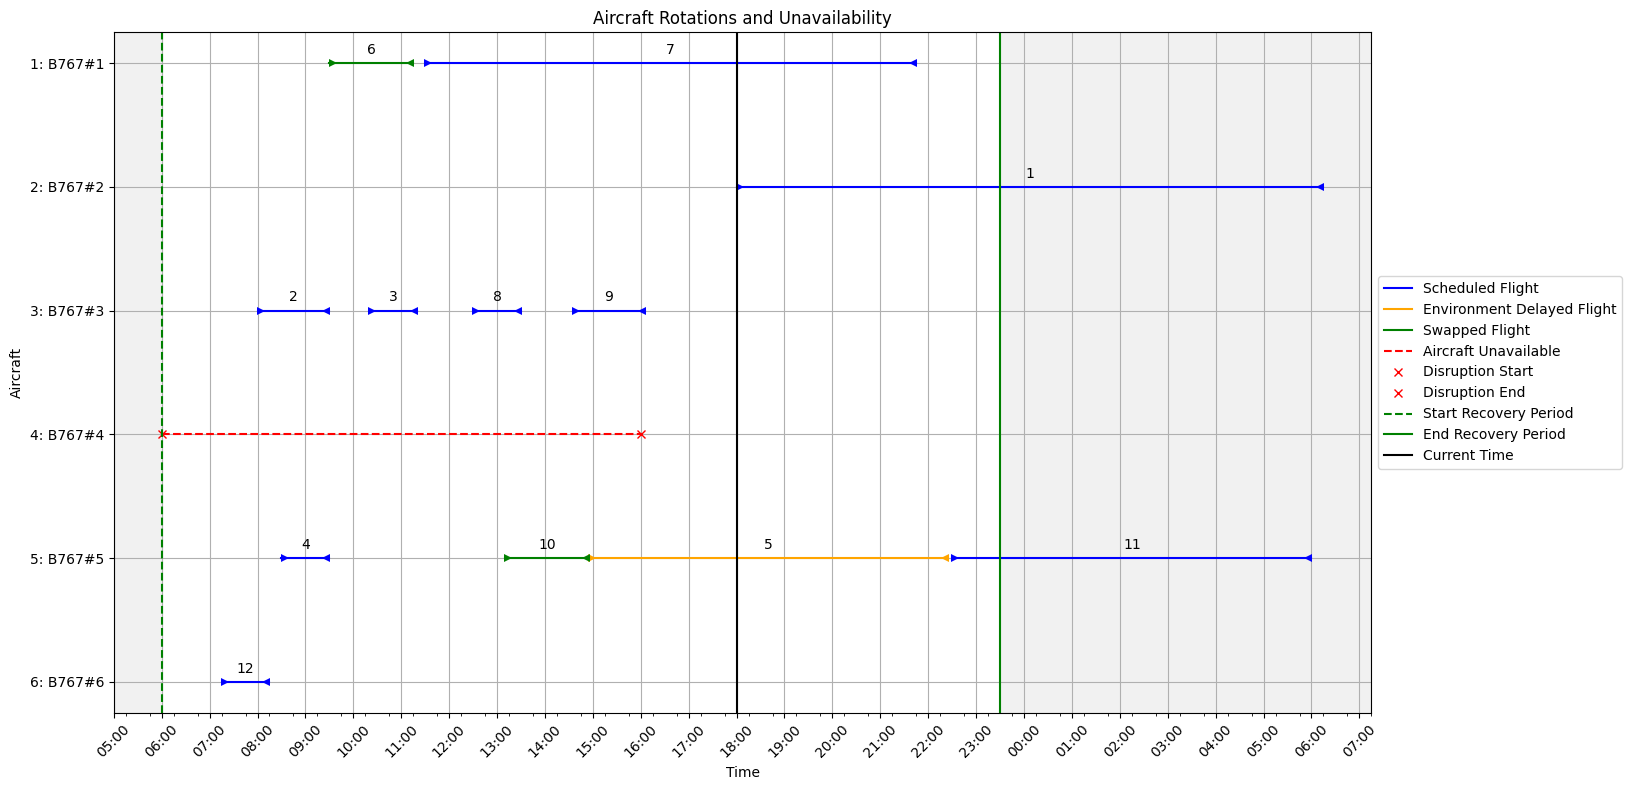

Action taken: [3], Reward: 0.0
Step 13:


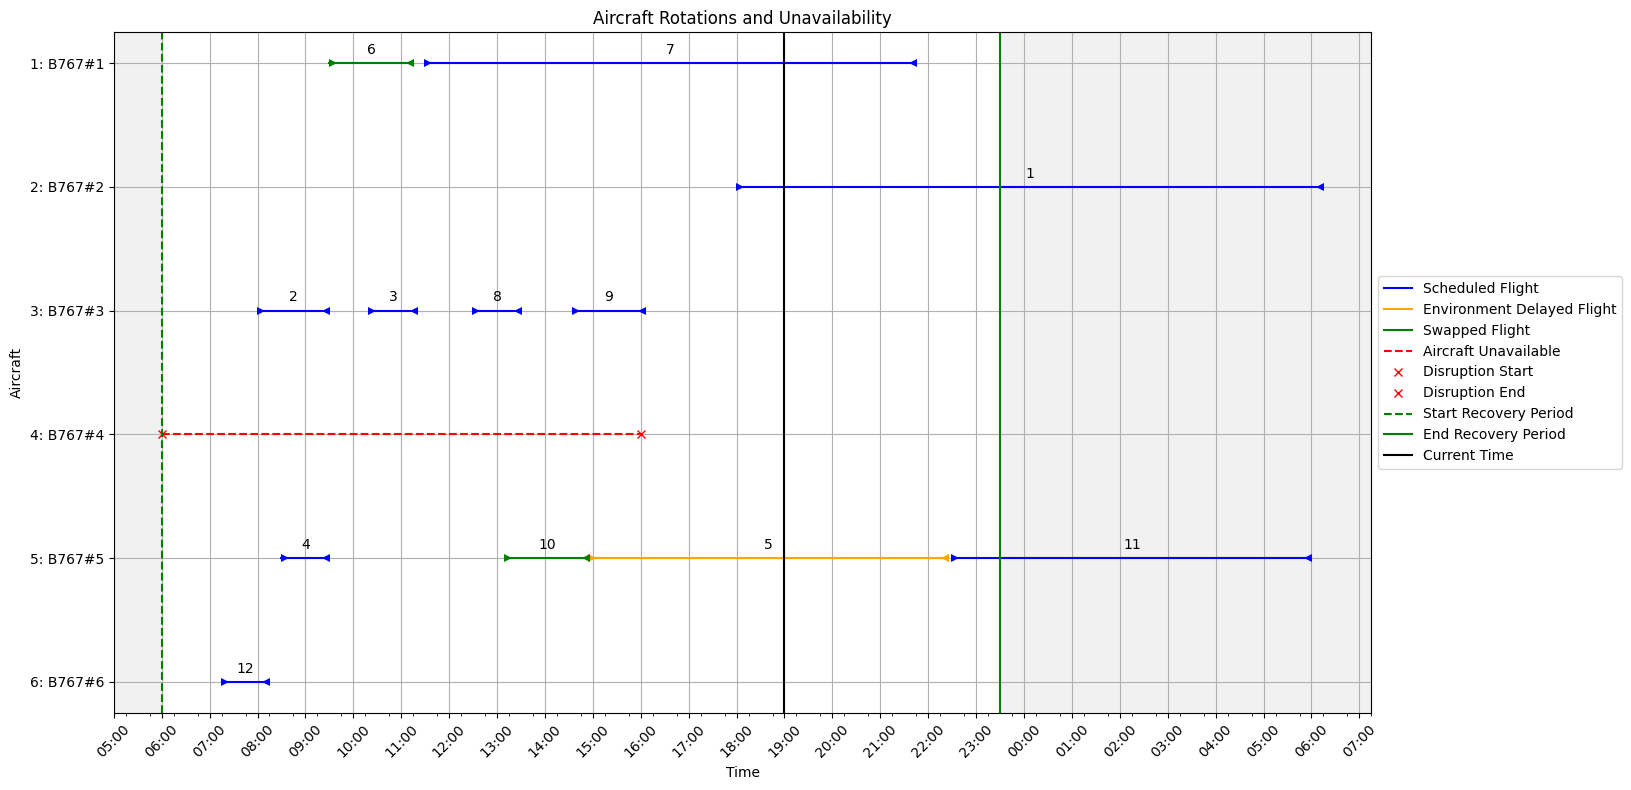

Action taken: [3], Reward: 0.0
Step 14:


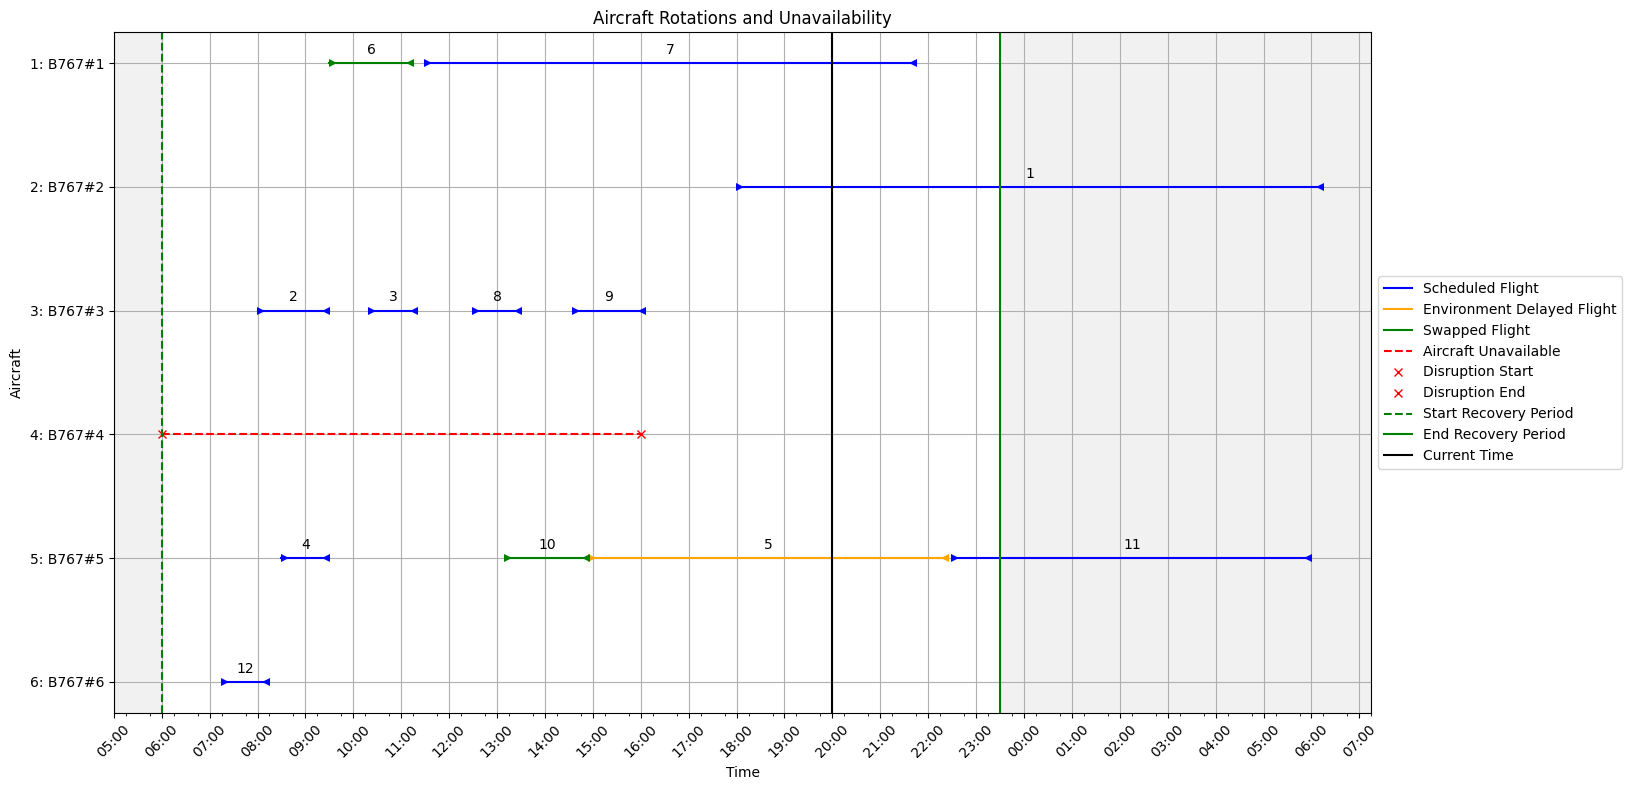

Action taken: [2], Reward: 0.0
Step 15:


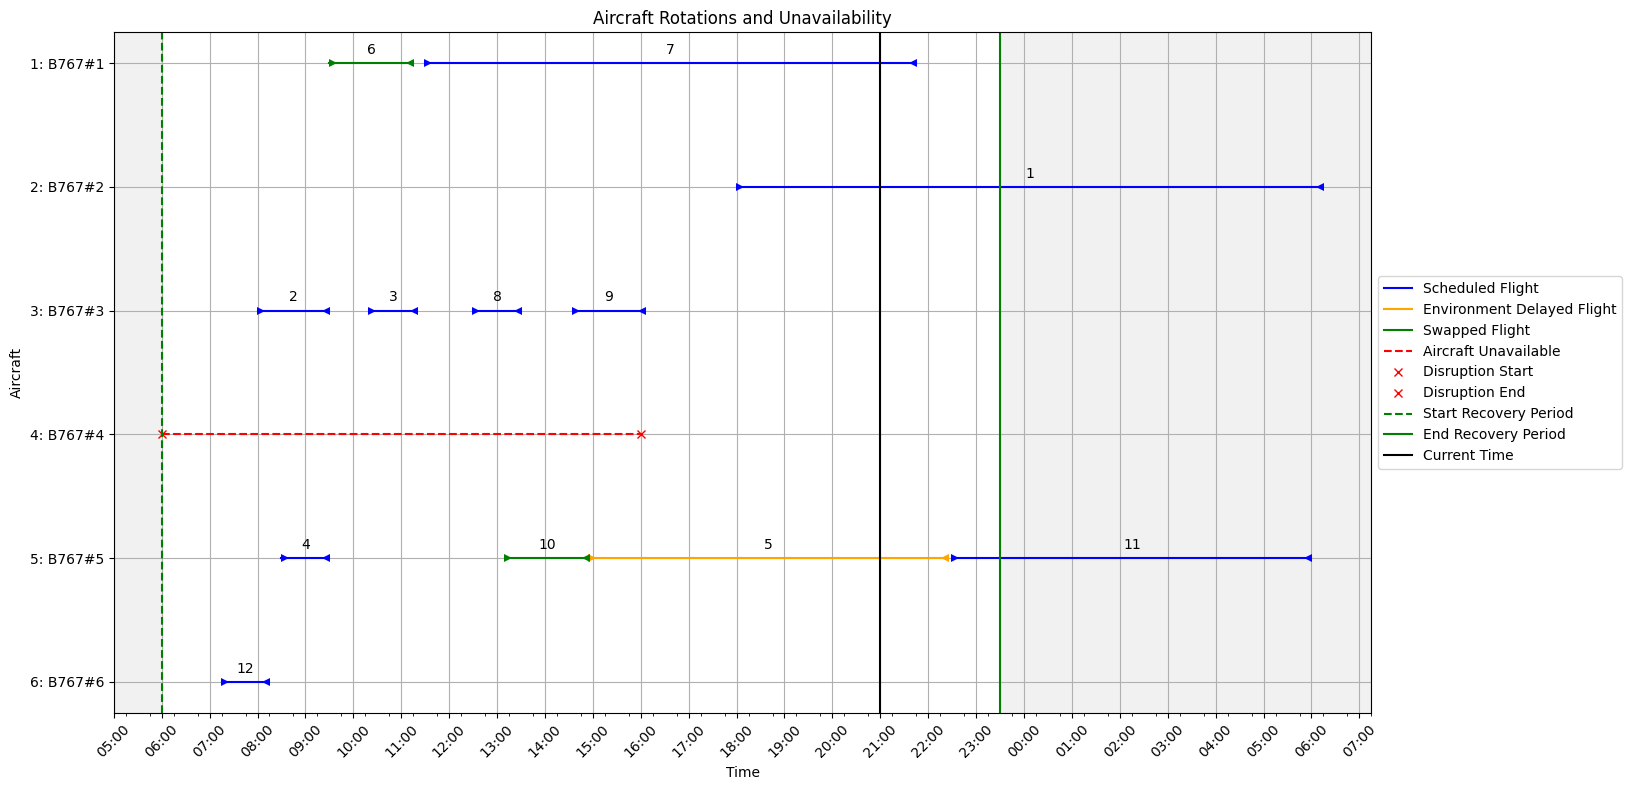

Action taken: [1], Reward: 0.0
Step 16:


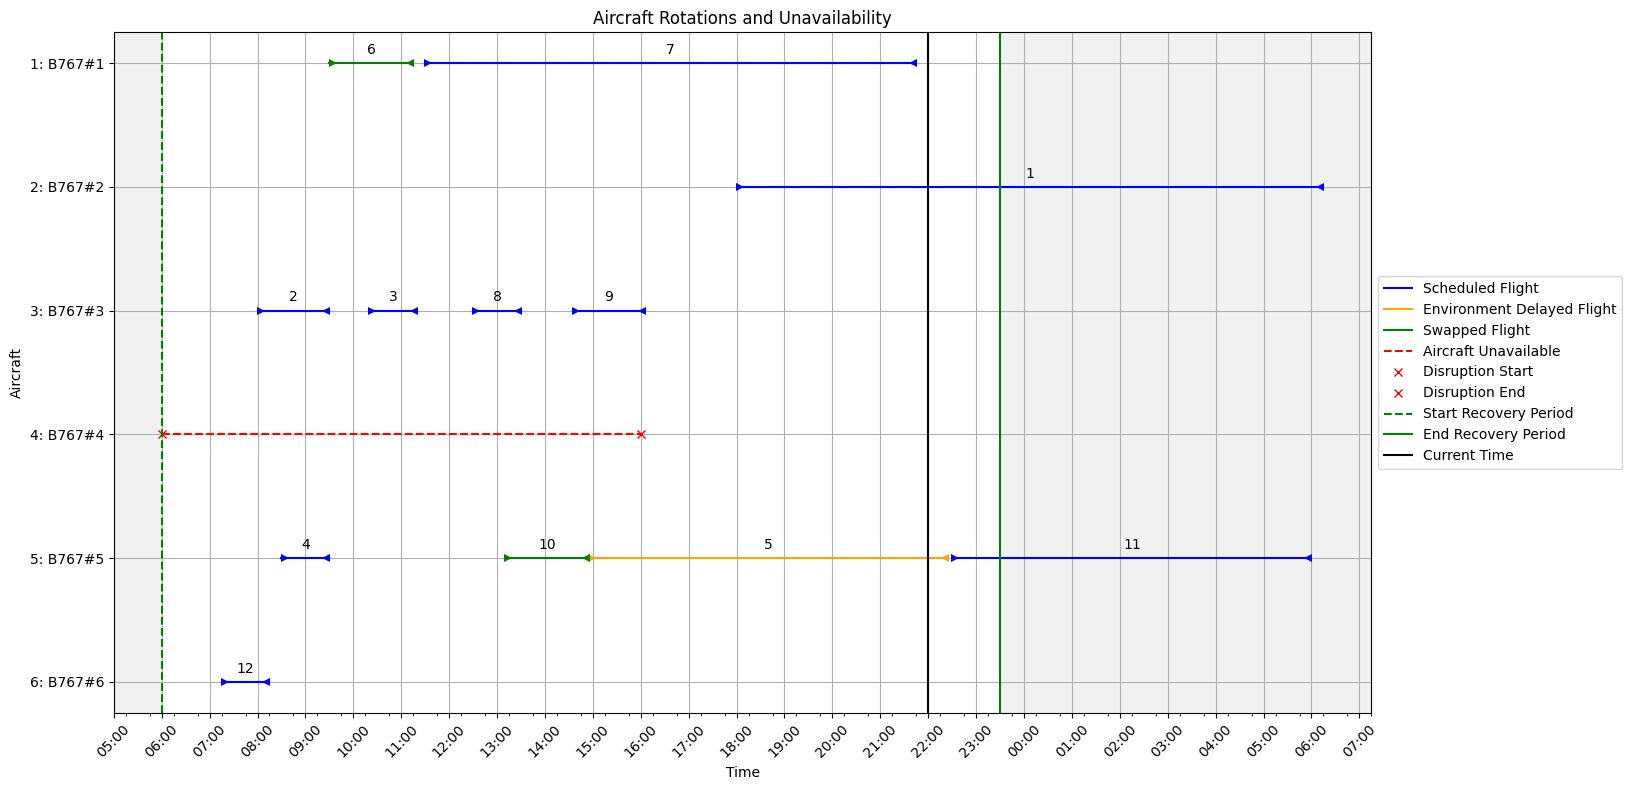

Action taken: [6], Reward: 0.0
Step 17:


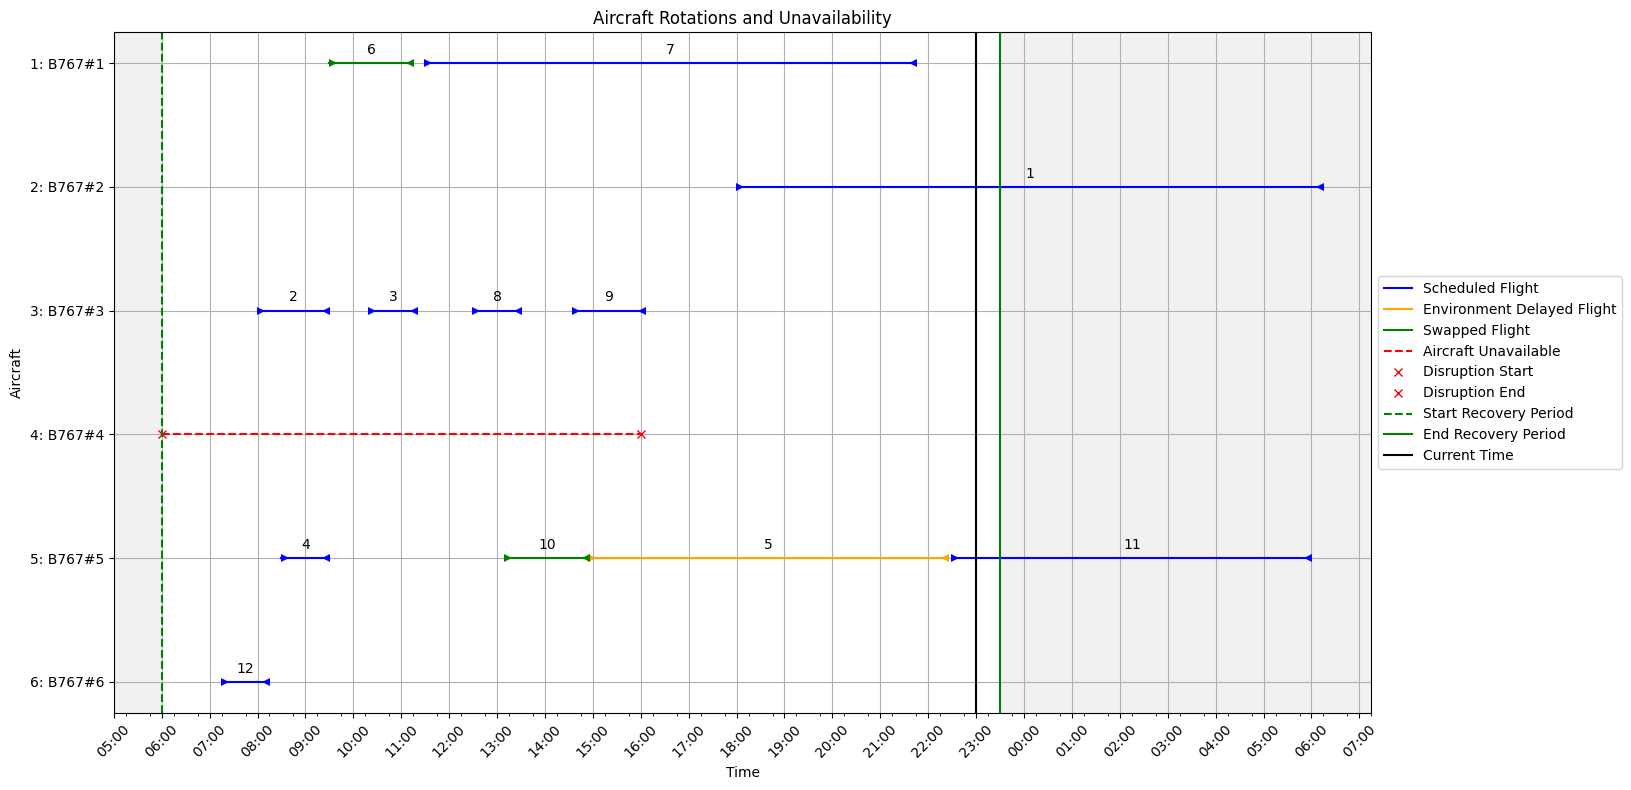

Action taken: [2], Reward: 0.0
Total Reward: 5125.0


In [1]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter

# Load the environment and scenario data function
def load_scenario_data(scenario_folder):
    file_keys = ['aircraft', 'airports', 'alt_aircraft', 'alt_airports', 'alt_flights', 'config', 'dist', 'flights', 'itineraries', 'position', 'rotations']
    file_paths = {key: os.path.join(scenario_folder, f"{key}.csv") for key in file_keys}

    data_dict = {}
    file_parsing_functions = {
        'config': FileParsers.parse_config,
        'airports': FileParsers.parse_airports,
        'dist': FileParsers.parse_dist,
        'flights': FileParsers.parse_flights,
        'aircraft': FileParsers.parse_aircraft,
        'rotations': FileParsers.parse_rotations,
        'itineraries': FileParsers.parse_itineraries,
        'position': FileParsers.parse_position,
        'alt_flights': FileParsers.parse_alt_flights,
        'alt_aircraft': FileParsers.parse_alt_aircraft,
        'alt_airports': FileParsers.parse_alt_airports
    }

    for file_type, file_path in file_paths.items():
        file_lines = read_csv_with_comments(file_path)
        if file_lines:
            parse_function = file_parsing_functions.get(file_type)
            if parse_function:
                parsed_data = parse_function(file_lines)
                data_dict[file_type] = parsed_data
            else:
                print(f"No parser available for file type: {file_type}")
        else:
            data_dict[file_type] = None
            print(f"{file_type.capitalize()} file is empty")

    return data_dict

# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment
    obs = env.reset()
    print("Observation shape:", obs.shape)

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict,
        flights_dict=flights_dict,
        rotations_dict=rotations_dict,
        alt_aircraft_dict=alt_aircraft_dict,
        start_datetime=env.get_attr('start_datetime')[0],
        end_datetime=env.get_attr('end_datetime')[0]
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Retrieve the updated flights_dict from the environment
        updated_flights_dict = env.get_attr('flights_dict')[0]

        # Use StatePlotter to plot the current state
        state_plotter.plot_state(updated_flights_dict, swapped_flights, environment_delayed_flights, current_datetime)

        # Sample a random action
        action = [env.action_space.sample()]  # Wrap in a list for DummyVecEnv

        # Step the environment
        obs, reward, done, info = env.step(action)

        # Extract values from arrays
        reward = reward[0]
        done = done[0]

        # Accumulate the reward
        total_reward += reward

        print(f"Action taken: {action}, Reward: {reward}")

        step_num += 1

    print(f"Total Reward: {total_reward}")

# Specify the scenario folder you want to use
SCENARIO_FOLDER = "../data/Example/PoC-scenario"  # Path to your scenario

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
